<a href="https://colab.research.google.com/github/lornamugambi/survival-analysis/blob/main/survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Survival Analysis in Python**

This is a branch of statistics used to analyse the expected duration until one or more events occur.  It is also referred to as duration analysis/duration modelling/time-to-event analysis/reliability analysis/event hostory analysis.

It is used to analyse:


*   A proportion of the population that survives upto a given time
*   Rate at which people are dying
*   Understanding the impact of covariates on survival

This kind of analysis is mostly used in the:
1. The medical field to understand patient's survival when diagnosed with a deadly disease. It is also used to predict patient readmission duration after major surgery
2. Transport: Predicting car battery life or waiting time for pedestrians after red phase
3. E-commerce: likelihood of a person purchasing a product after seeing an ad
4. Human resource: Likelihood of an employee leaving a company


To understand time to event data the following models are used:
1. Kaplan-Maier Estimate (non-parametric)
2. Cox proportional Hazard Model (semi-parametric)
3. Accelerated Failure time Model (parametric)



In time-to-event analysis, **"parametric"** models assume a specific underlying distribution for the survival time, while** "semi-parametric"** models only assume the proportional hazards relationship between covariates and the hazard function, leaving the baseline hazard unspecified, and **"non-parametric"** models make minimal assumptions about the data distribution, often relying on ranking information to estimate survival probabilities, with the most common example being the **Kaplan-Meier curve**.



**Key differences:**
**Assumptions:**
* Parametric: Requires specifying the exact distribution of survival times (e.g., exponential, Weibull).
* Semi-parametric: Only assumes the proportional hazards assumption, allowing for a flexible baseline hazard function.
* Non-parametric: Makes minimal assumptions about the data distribution, often just requiring the ability to rank events.


Advantages:
* Parametric: Can provide more detailed information like mean survival time and can be more efficient with smaller sample sizes if the assumed distribution is accurate.
* Semi-parametric: More flexible than parametric models, especially when the exact distribution is unknown but the proportional hazards assumption holds.
* Non-parametric: Robust to violations of distributional assumptions, easy to interpret, and good for visualizing survival data.



Common examples:
* Parametric: Exponential regression, Weibull regression
Semi-parametric: Cox proportional hazards model
* Non-parametric: Kaplan-Meier survival curve


When to use which method:
* Use parametric:
When you have strong prior knowledge about the underlying survival time distribution and want to estimate specific parameters like mean survival time.
* Use semi-parametric:
This is often the preferred choice when you want to analyze the effect of covariates on survival time without making strong assumptions about the baseline hazard.
* Use non-parametric:
When you are unsure about the underlying distribution or want a simple visual representation of survival data, especially when dealing with small sample sizes.

**Survival of Lung Cancer patients using time to event analysis**

In [2]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=716d0d8e69c106362baa1081a42bfb3d4b9b0f94671519d3c2eae143ef92872c
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [3]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter  #survival analysis
import matplotlib.pyplot as plt

Lung Cancer Data

The data consist of 228 observations and 10 variables/columns. The variable description is presented as the following:

* inst: Institution code
* time (d1): Survival time in days
* status (d2): censoring status 1 = censored, 2 = dead
* age (i1): Age in years
* sex (i2): Male = 1 Female = 2
* ph.ecog (i3): ECOG performance score as rated by the physician. 0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed <50% of the day, 3 = in bed > 50% of the day but not bed bound, 4 = bed bound
* ph.karno (i4): Karnofsky performance score (bad = 0; good = 100) rated by physician
* pat.karno (i4): Karnofsky performance score as rated by patient
* meal.cal (i5): Calories consumed at meals
* wt.loss (i6): Weight loss in last six months


Where: ‘i’ indicates the independent variables (covariates), and ‘d’ indicates dependent variables. Actually, the dependent variable or response is the time until the occurrence of an event (i.e., the lung cancer patient dies).

In [10]:
# prompt: loading a csv from a http link

import pandas as pd
import requests
from io import StringIO

# Replace 'your_http_link' with the actual link to your CSV file
url = 'https://www.key2stats.com/NCCTG_Lung_Cancer_Data_535_29.csv'

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

    csv_data = StringIO(response.text)
    data = pd.read_csv(csv_data, index_col = 0)

    # Now you can work with the DataFrame 'df'
    print(data.head())  # Display the first few rows

except requests.exceptions.RequestException as e:
    print(f"Error downloading the CSV file: {e}")

except pd.errors.ParserError as e:
    print(f"Error parsing the CSV file: {e}")


   X  inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
2  2     3   455       2   68    1        0        90         90      1225   
4  4     5   210       2   57    1        1        90         60      1150   
6  6    12  1022       1   74    1        1        50         80       513   
7  7     7   310       2   68    2        2        70         60       384   
8  8    11   361       2   71    2        2        60         80       538   

   wt.loss  
2       15  
4       11  
6        0  
7       10  
8        1  


In [11]:
data.shape

(167, 11)

In [12]:
#one hot encoding for sex(make vs female) and status(censored vs dead) columns

data = data[['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']]
data['status'] = data['status'] - 1
data['sex'] = data['sex'] - 1
data.head()

<ipython-input-12-2a688e2f8046>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['status'] = data['status'] - 1
<ipython-input-12-2a688e2f8046>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sex'] = data['sex'] - 1


,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
2,455,1,68,0,0,90,90,1225,15
4,210,1,57,0,1,90,60,1150,11
6,1022,0,74,0,1,50,80,513,0
7,310,1,68,1,2,70,60,384,10
8,361,1,71,1,2,60,80,538,1


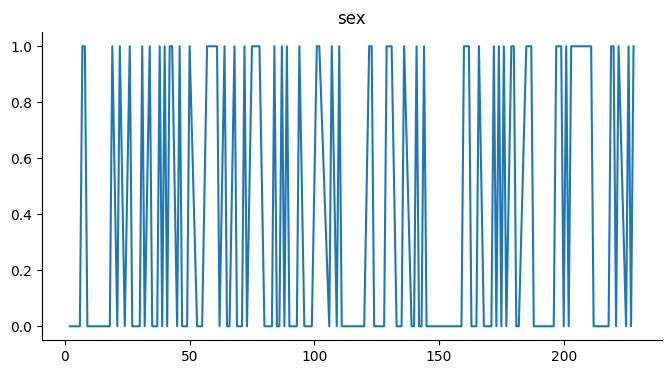

In [32]:
# @title sex

from matplotlib import pyplot as plt
data['sex'].plot(kind='line', figsize=(8, 4), title='sex')
plt.gca().spines[['top', 'right']].set_visible(False)

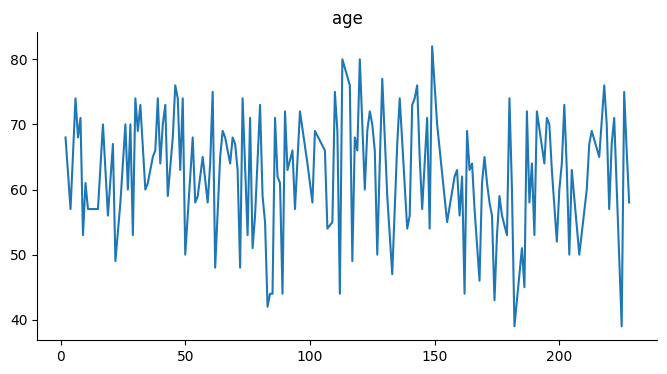

In [31]:
# @title age

from matplotlib import pyplot as plt
data['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

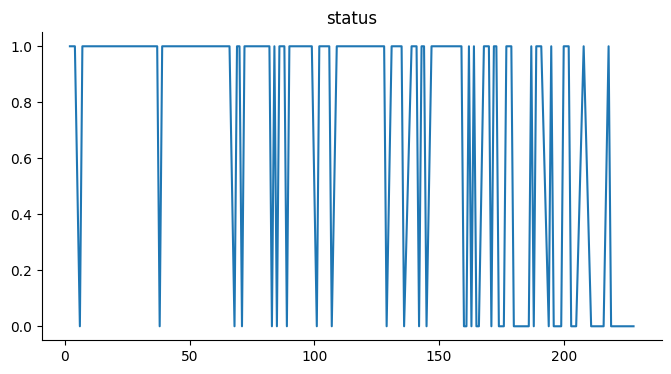

In [30]:
# @title status

from matplotlib import pyplot as plt
data['status'].plot(kind='line', figsize=(8, 4), title='status')
plt.gca().spines[['top', 'right']].set_visible(False)

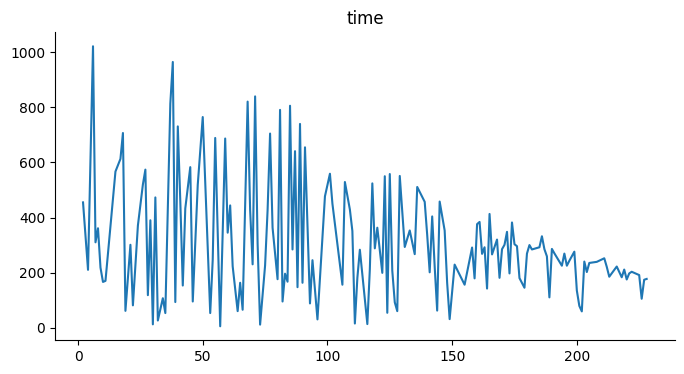

In [29]:
# @title time

from matplotlib import pyplot as plt
data['time'].plot(kind='line', figsize=(8, 4), title='time')
plt.gca().spines[['top', 'right']].set_visible(False)

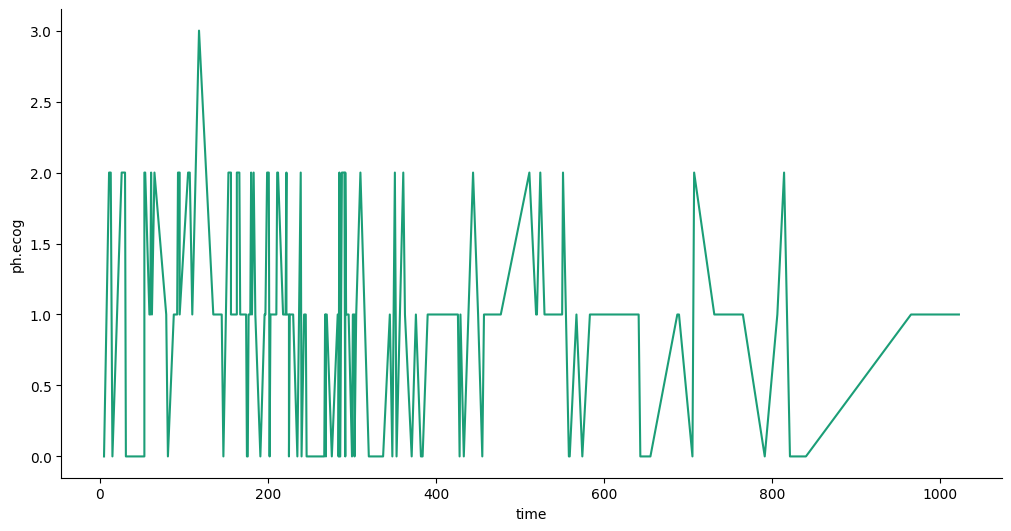

In [28]:
# @title time vs ph.ecog

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['ph.ecog']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('ph.ecog')

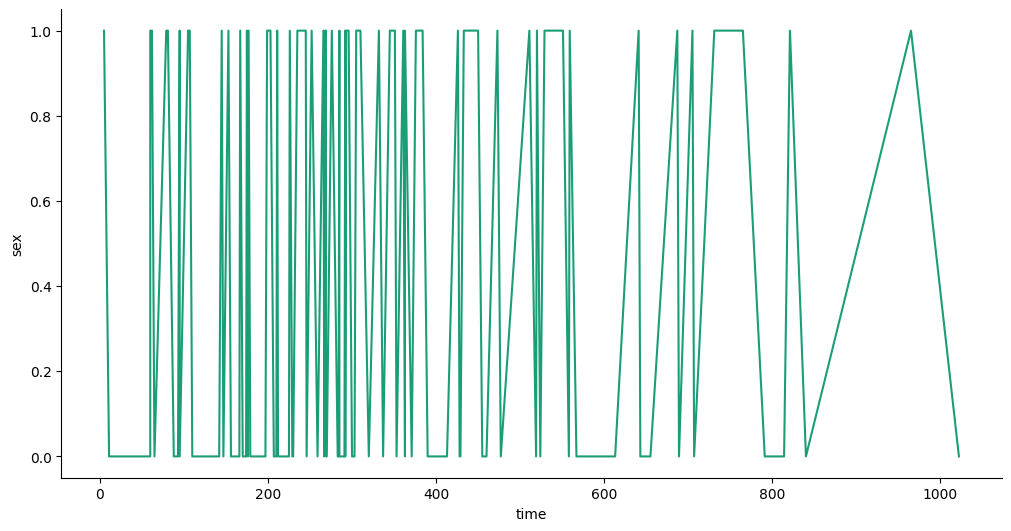

In [27]:
# @title time vs sex

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['sex']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('sex')

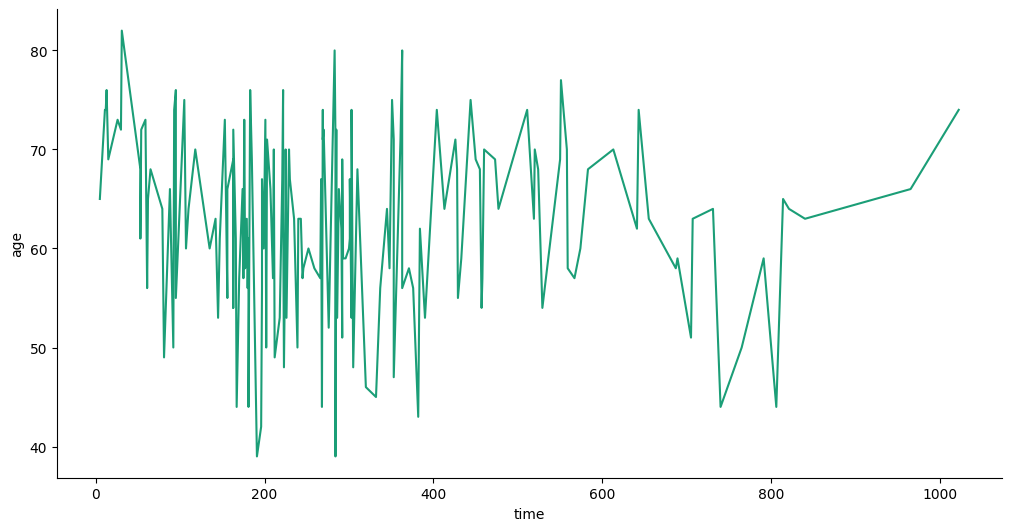

In [26]:
# @title time vs age

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['age']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('age')

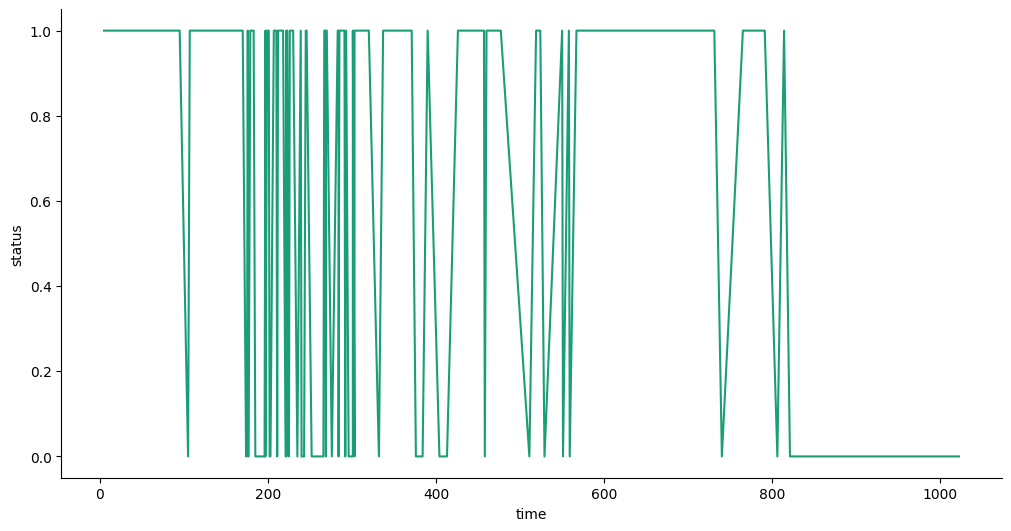

In [25]:
# @title time vs status

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['status']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('status')

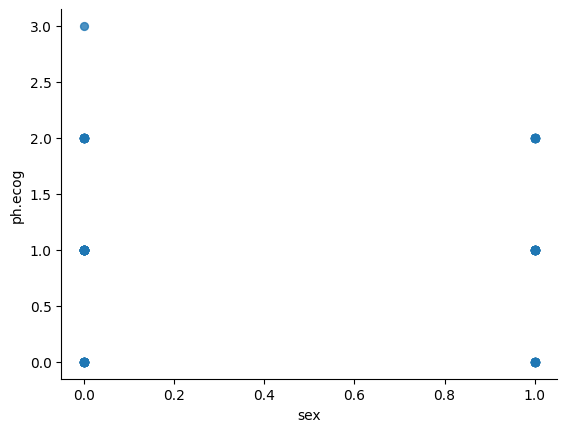

In [24]:
# @title sex vs ph.ecog

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='sex', y='ph.ecog', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

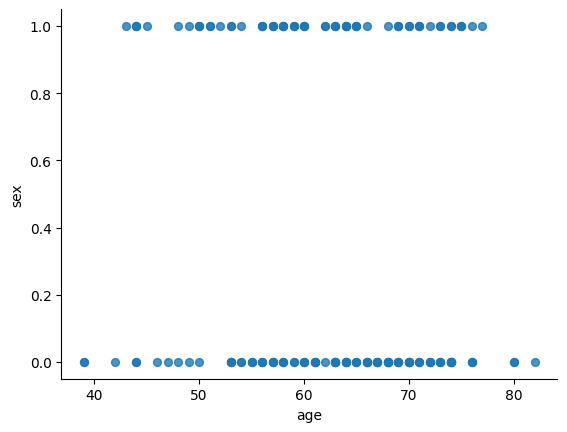

In [23]:
# @title age vs sex

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='age', y='sex', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

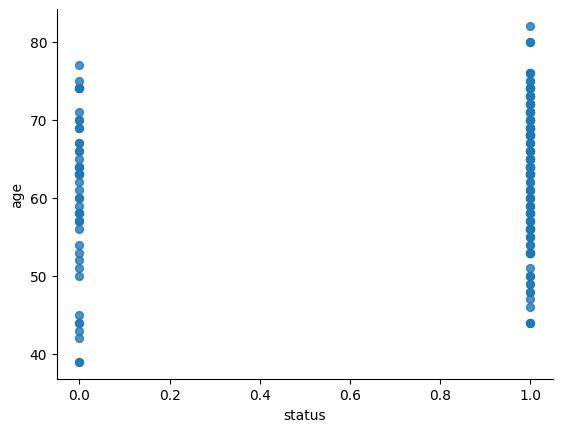

In [22]:
# @title status vs age

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='status', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

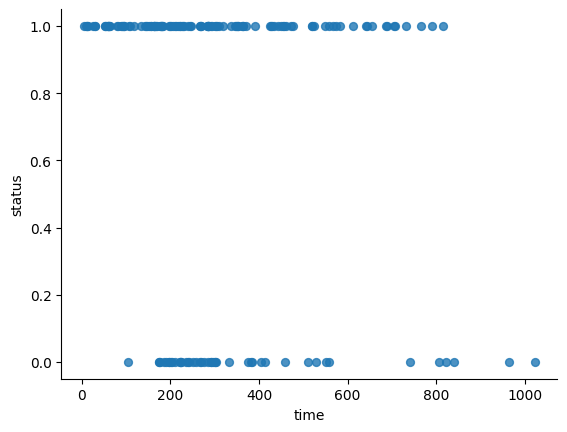

In [21]:
# @title time vs status

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='time', y='status', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

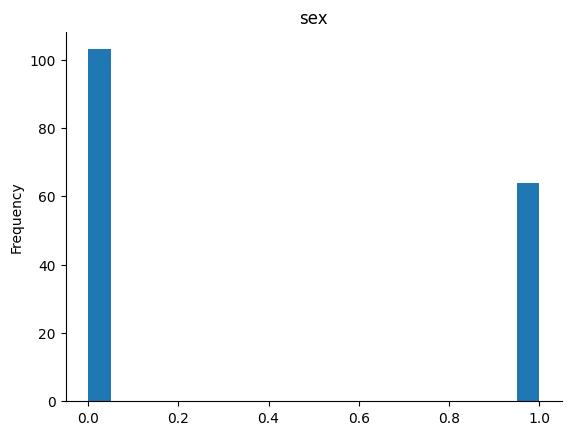

In [20]:
# @title sex

from matplotlib import pyplot as plt
data['sex'].plot(kind='hist', bins=20, title='sex')
plt.gca().spines[['top', 'right',]].set_visible(False)

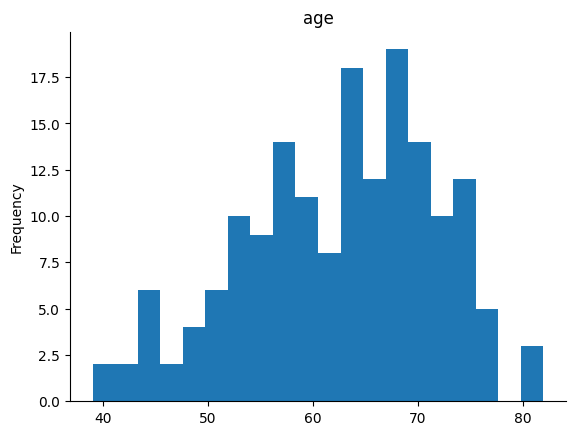

In [19]:
# @title age

from matplotlib import pyplot as plt
data['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
data.dtypes

,0
time,int64
status,int64
age,int64
sex,int64
ph.ecog,int64
ph.karno,int64
pat.karno,int64
meal.cal,int64
wt.loss,int64


In [14]:
#checking and handling missing values(either remove or use a mean/median value to impute missing values)
data.isnull().sum()

,0
time,0
status,0
age,0
sex,0
ph.ecog,0
ph.karno,0
pat.karno,0
meal.cal,0
wt.loss,0


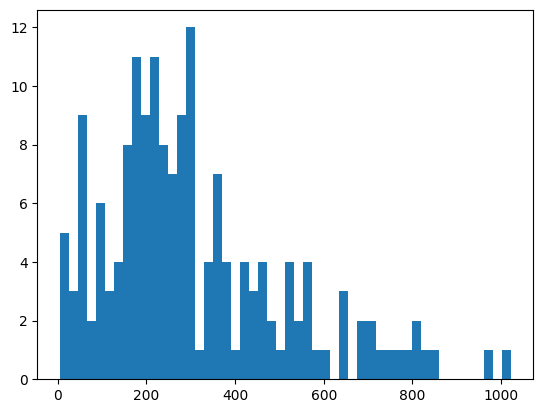

In [15]:
#data distribution
T = data['time']
E = data['status']

plt.hist(T, bins=50)
plt.show()

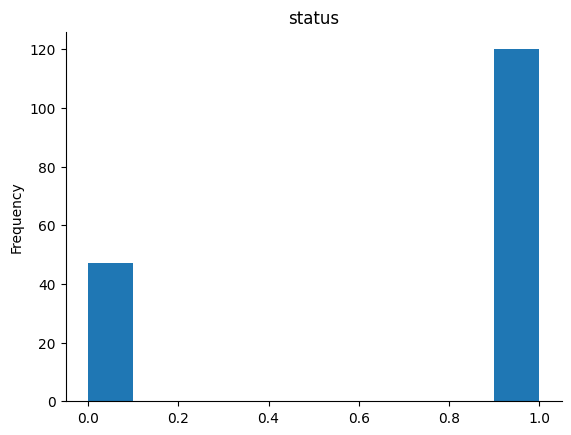

In [18]:
#status
data['status'].plot(kind='hist', bins=10, title='status')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Kaplan-Maier Curve Estimation (non-parametric)**

Generating a Kaplan-Maier curve can help plot a survival curve of the overall data. This approach, also called the product-limit approach re-estimates the survival probability each time an event occurs.

It is a npn-parametric method meaning it doesn't assume the distribution of the outcome variab;e i.e. time

<Axes: xlabel='timeline'>

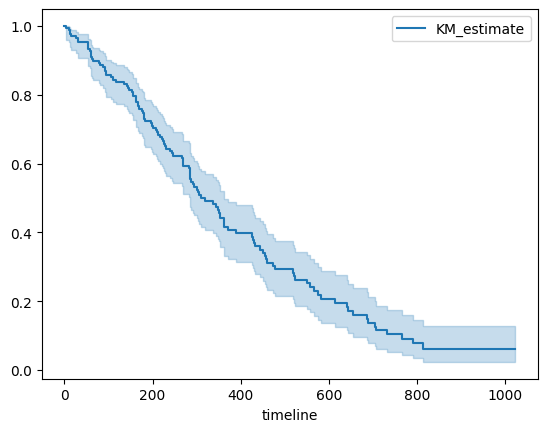

In [33]:
#instantiate
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
kmf.plot_survival_function()

The curve shows how survival probabilities cahnge over time, which is reduce.

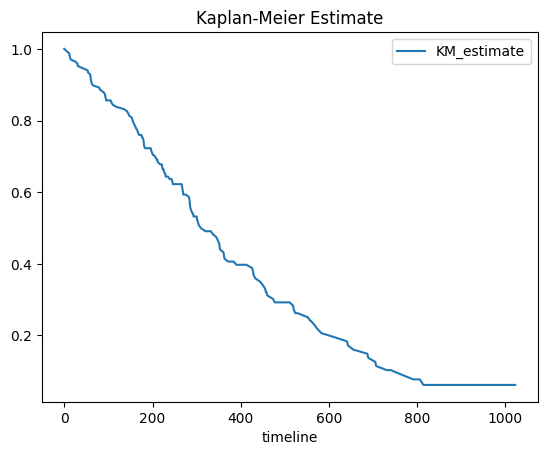

In [35]:
#same plot with 95% confidence interval
kmf.survival_function_.plot()
plt.title('Kaplan-Meier Estimate')
plt.show()

**Failure curve**

This ideally is the opposite of survival i.e. failure/death probabilities over time.

<Axes: xlabel='timeline'>

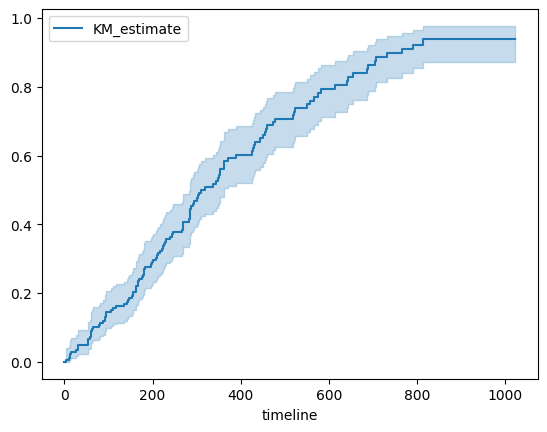

In [36]:
kmf.plot_cumulative_density()

In [37]:
#median survival times and 95% confidence intervals
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print(median_)
print(median_confidence_interval_)

310.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   284.0                   363.0


Here, the median survival time is 310 days, which indicates that 50% of the sample live 310 days and 50% dies within this time. The 95% CI lower limit is 284 days, while the upper limit is 363 days.

**KM Plot for Gender/Sex Categories**

Using the KM estimate, we can check the difference between categorical groups. Though, it is only viable when the variable has fewer categories. Here is an example where we are plotting the two survival curves, one for Male and another for Female.

Text(0.5, 1.0, 'Survival of different gender group')

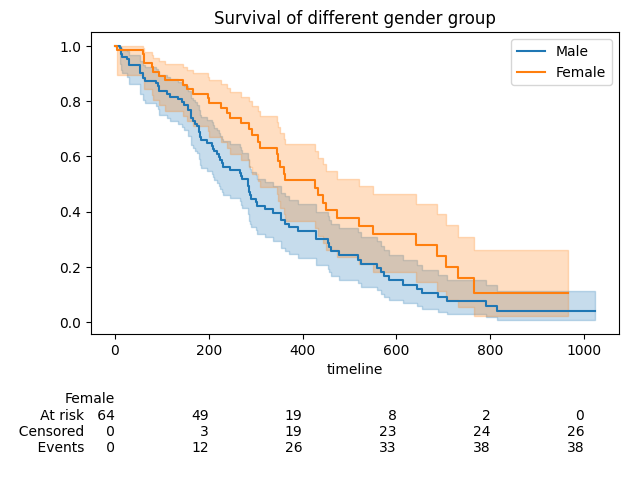

In [38]:
ax = plt.subplot(111)
m = (data["sex"] == 0)

kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)

plt.title("Survival of different gender group")

The curve illustrates that the survival probabilities of female patients are overall higher compared to male patients at any instance of time

**KM Plot for ph.ecog Categories**


Similar to Gender/Sex, we can also plot separate survival curves for other categorical variables. Here, I have used a for loop that iterate over all ph.ecog categories and plot their survival function over a single plot.

The fourth plot (row 2, column 2) where the ecog == 3, looks incomplete.


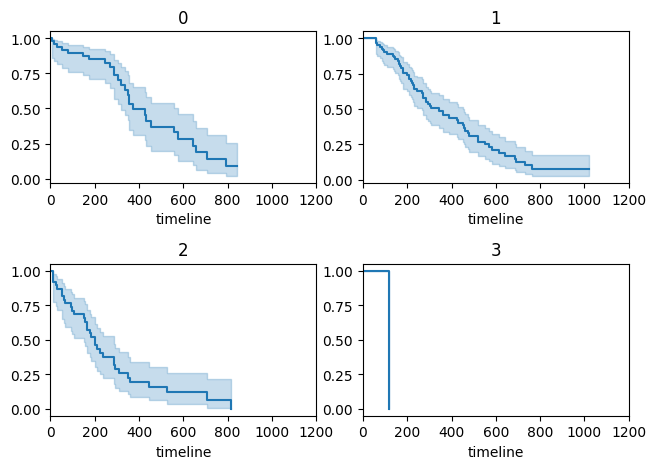

In [39]:
ecog_types = data.sort_values(by = ['ph.ecog'])["ph.ecog"].unique()
for i, ecog_types in enumerate(ecog_types):
  ax = plt.subplot(2, 2, i + 1)
  ix = data['ph.ecog'] == ecog_types
  kmf.fit(T[ix], E[ix], label = ecog_types)
  kmf.plot_survival_function(ax = ax, legend = False)
  plt.title(ecog_types)
  plt.xlim(0, 1200)
plt.tight_layout()

We can further investigate the ph.ecog == 3 using value_counts( ) method. It shows that the category 3 has only one observation which does not contribute much if we fit a model.

In [40]:
data['ph.ecog'].value_counts()

,count
ph.ecog,
1,81
0,47
2,38
3,1


Thus, we need to remove this observation from the data. We can achieve this using a filtering process as shown below. Now, the dataset contains 116 observations and 9 variables.

In [41]:
data = data[data["ph.ecog"] != 3]
data.shape

(166, 9)

In [43]:
#confirm 3rd category was removed
data['ph.ecog'].value_counts()

,count
ph.ecog,
1,81
0,47
2,38


**Cox Proportional Hazard Model (Semi-Parametric)**


Cox-PH model is a semi-parametric model which solves the problem of incorporating covariates. In Cox’s proportional hazard model, the log-hazard is a linear function of the covariates and a population-level baseline hazard.

Hazard = h(t|x) = Baseline hazard + Partial hazard

Where:

Baseline hazard = 𝖻ₒt
Partial hazard = exp (∑ⁿᵢ bᵢ(xᵢ- x̂))



In the above equation, the first term is the baseline hazard and the second term known as partial hazard. The partial hazard inflates or deflates the baseline hazard based on covariates.

**Cox-PH Model Assumptions**

Cox proportional hazards regression model assumptions includes:

Independence of survival times between distinct individuals in the sample
A multiplicative relationship between the predictors and the hazard, and
A constant hazard ratio over time.

**Definition of Hazard and Hazard Ratio**

Hazard is defined as the slope of the survival curve. It is a measure of how rapidly subjects are dying.
The hazard ratio compares two groups. If the hazard ratio is 2.0, then the rate of deaths in one group is twice the rate in the other group.

***Data Preparation***

For fitting the Cox-PH model, we need to do some preprocessing of the categorical variables. Especially the dummy coding. The sex variable is binary, so we don’t have to dummy code it, until unless we want to alter the coding scheme, i.e., 0 for female and 1 for male. Here, we need to dummy code the ph.ecog variable only.

In [44]:
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
2,455,1,68,0,0,90,90,1225,15
4,210,1,57,0,1,90,60,1150,11
6,1022,0,74,0,1,50,80,513,0
7,310,1,68,1,2,70,60,384,10
8,361,1,71,1,2,60,80,538,1


**Dummy Coding**


We can dummy code the ph.ecog variable using pandas pd.get_dummies( ) method. I have added the prefix identifier for the generated columns. Here, we will consider the ecog_0 as the base category, so in next step we will remove it.

In [45]:
dummies_ecog = pd.get_dummies(data["ph.ecog"], prefix = 'ecog')
dummies_ecog.head(4)

,ecog_0,ecog_1,ecog_2
2,True,False,False
4,False,True,False
6,False,True,False
7,False,False,True


In [46]:
#concatenate & drop the original categorical value
dummies_ecog = dummies_ecog[["ecog_1", "ecog_2"]]
data = pd.concat([data, dummies_ecog], axis = 1)
data = data.drop("ph.ecog", axis = 1)
data.head()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
2,455,1,68,0,90,90,1225,15,False,False
4,210,1,57,0,90,60,1150,11,True,False
6,1022,0,74,0,50,80,513,0,True,False
7,310,1,68,1,70,60,384,10,False,True
8,361,1,71,1,60,80,538,1,False,True


In [47]:
#fit model

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(data, duration_col = 'time', event_col = 'status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 166 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 119
   partial log-likelihood = -489.65
         time fit was run = 2025-02-19 08:59:08 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
sex       -0.55      0.58      0.20           -0.95           -0.15                0.39                0.86
ph.karno   0.02      1.02      0.01           -0.00            0.04                1.00                1.05
pat.karno -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
meal.cal   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
ecog_1     0.65      1.91      0.28            0.09            1.20                1.10                3.32
ecog_2     1.45      4.28      0.46            0.55            2.36                1.73               10.59

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  0.85   0.40      1.34
sex          0.00 -2.71   0.01      7.23
ph.karno     0.00  1.95   0.05      4.30
pat.karno    0.00 -1.34   0.18      2.46
meal.cal     0.00  0.10   0.92      0.12
wt.loss      0.00 -1.83   0.07      3.88
ecog_1       0.00  2.29   0.02      5.52
ecog_2       0.00  3.15 <0.005      9.25
---
Concordance = 0.65
Partial AIC = 995.29
log-likelihood ratio test = 26.72 on 8 df
-log2(p) of ll-ratio test = 10.31

The summary table provides coefficients, exp(coef): also known as Hazard Ratio, confidence intervals, z and p-values.

**Interpretation of Cox-PH Model Results/Estimates**

The interpretation of the model estimates will be like this:

* Wt.loss has a coefficient of about -0.01. We can recall that in the Cox proportional hazard model, a higher hazard means more at risk of the event occurring. Here, the value of exp(-0.01) is called the hazard ratio.
* It shows that a one unit increase in wt loss means the baseline hazard will increase by a factor of exp(-0.01) = 0.99 ⇾ about a 1% decrease.
* Similarly, the values in the ph.ecog column are: [0 = asymptomatic, 1 = symptomatic but completely ambulatory and 2 = in bed <50% of the day]. The value of the coefficient associated with ecog2, exp(1.20), is the value of ratio of hazards (Hazard Ratio) associated with being “in bed <50% of the day (coded as 2)” compared to asymptomatic (coded as 0, base category). This indicates the risk (rate) of dying is 3.31 times for patients who are “in bed <50% of the day” compared to asymptomatic patients.

<Axes: xlabel='log(HR) (95% CI)'>

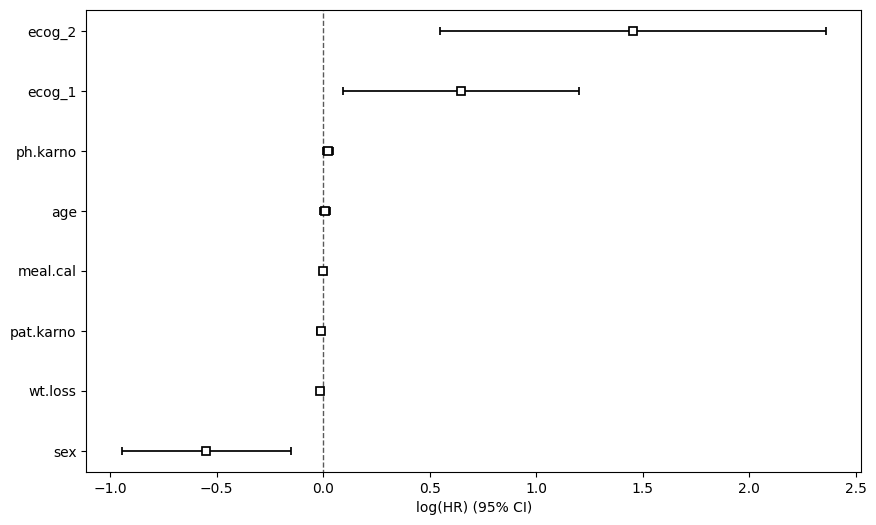

In [49]:
#plot coefficients/ ranking of variables in terms of their log(HR)
plt.subplots(figsize = (10, 6))
cph.plot()

**Plot Partial Effects on Outcome (Cox-PH Regression)**

We can use our fitted model to see how the survival changes as we change the covariate values. Here, I have used the plot_partial_effects_on_outcome( ) method to see how the survival varies for age group of 50, 60, 70 and 80 years old patents compared to their baseline function. It clearly highlights that young patents has higher survival probabilities at any given instance of time compared to old patients.

<Axes: >

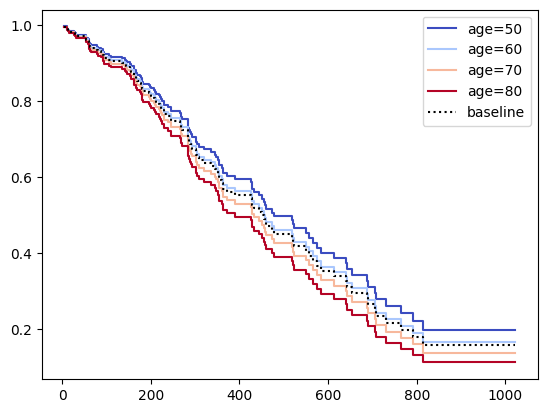

In [50]:
cph.plot_partial_effects_on_outcome(covariates = 'age', values = [50, 60, 70, 80], cmap = 'coolwarm')

**Check Proportional Hazard Assumption**

Once we fit the model, the next step is to verify the proportional hazard assumption. We can directly use the check_assumptions( ) method that return a log rank test statistics.

The null (Hₒ) hypothesis assumed that the proportional hazard criteria satisfied, while alternative hypothesis (H\_1) infer that the proportional hazard assumption criteria not met (violated).

In [51]:
cph.check_assumptions(data, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 166 total observations, 47 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
age       km              1.34 0.25      2.01
          rank            0.79 0.37      1.42
ecog_1    km              0.47 0.49      1.02
          rank            0.45 0.50      1.00
ecog_2    km              0.05 0.83      0.27
          rank            0.02 0.88      0.18
meal.cal  km              4.90 0.03      5.22
          rank            4.40 0.04      4.80
pat.karno km              0.01 0.92      0.11
          rank            0.00 0.99      0.02
ph.karno  km              3.11 0.08      3.69
          rank            2.79 0.09      3.40
sex       km              2.76 0.10      3.37
          rank            2.57 0.11      3.19
wt.loss   km              0.59 0.44      1.18
          rank            0.70 0.40      1.32



1. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0268.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'meal.cal' using pd.cut, and then specify it in
`strata=['meal.cal', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#

[]

We can also use the proportional_hazard_test( ) method to perform the same.

The result revealed that at 5% significance level, only meal.cal violated the assumption. There are various approach to deal with it, for example we can convert it to a binned category, or we can use a parametric Cox-PH mod

In [52]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 166 total observations, 47 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
age                  0.79 0.37      1.42
ecog_1               0.45 0.50      1.00
ecog_2               0.02 0.88      0.18
meal.cal             4.40 0.04      4.80
pat.karno            0.00 0.99      0.02
ph.karno             2.79 0.09      3.40
sex                  2.57 0.11      3.19
wt.loss              0.70 0.40      1.32

**Accelerated Failure Time (AFT) Model**
If the proportional hazard assumption criteria of Cox-PH model is not satisfied, in such instance, a better approach is to use a parametric model. Accelerated Failure Time (AFT) is one of the popular parametric model used in survival analysis.

The model assumes that the survival function follows a parametric continuous distribution. For instance, one can assume a Weibull distribution or a Log-normal distribution.

The parametric AFT model assumes that survival function that derived from say two population (for example P and Q) are related by some acceleration factor lambda (λ), which can be modelled as a function of covariates.


Acceleration Factor/Time Ratio as a function of covariates
Based on the covariates, the AFT model can accelerate or decelerate the failure times. The AFT model coefficients can be interpreted easily: a unit increase in a covariate means the average/median survival time changes by a factor of exp(b_i) [2].

**Identifying the Best Fitted Distribution**

There are many distributions exist that we can fit. So, the first step is to identify the best distribution that best fits the data. The common distributions are Weibull, Exponential, Log-Normal, Log-Logistic and Generalized Gamma.

Here is a step-by-step guide for identifying best fitted distribution:

Import distributions from lifelines library
Instantiate the class object and save inside a variable. For example, here the Weibull class object has been saved inside “wb”
Iterate through all model objects and fit with the time and event data
Print the AIC value
The distribution with the lowest AIC value presents the best fitted distribution
Here, the Weibull provided the lowest AIC (1673.4) value thus, it can be selected as best fitted distribution for our AFT model.

In [57]:
from lifelines import WeibullFitter,ExponentialFitter,LogNormalFitter,LogLogisticFitter

wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data and print AIC for each model
models = [wb, ex, log, loglogis]
for model in models:
    model.fit(durations = data["time"], event_observed = data["status"])
    print(f"The AIC value for {model.__class__.__name__} is {model.AIC_}")

The AIC value for WeibullFitter is 1673.3773647144624
The AIC value for ExponentialFitter is 1685.3615565258144
The AIC value for LogNormalFitter is 1698.4726084809697
The AIC value for LogLogisticFitter is 1685.547074862081


**Fitting Weibull AFT Model**

The next step is to fit the Weibull Fitter class with the lung cancer data and print the summary. The model estimate provides coefficients, exp(coef) also known as Acceleration Factor/ Time Ratio, confidence intervals, z statistics and p-values.

In [58]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col='time', event_col='status')
weibull_aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 166 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 166
number of events observed = 119
           log-likelihood = -821.178
         time fit was run = 2025-02-19 09:19:51 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ age       -0.006     0.994     0.008          -0.022           0.010               0.979               1.010
        ecog_1    -0.440     0.644     0.195          -0.823          -0.057               0.439               0.944
        ecog_2    -1.048     0.351     0.319          -1.674          -0.422               0.187               0.655
        meal.cal  -0.000     1.000     0.000          -0.000           0.000               1.000               1.000
        pat.karno  0.008     1.008     0.006          -0.004           0.019               0.996               1.019
        ph.karno  -0.016     0.984     0.008          -0.031          -0.001               0.969               0.999
        sex        0.390     1.477     0.143           0.110           0.671               1.116               1.955
        wt.loss    0.010     1.010     0.005          -0.001           0.020               0.999               1.020
        Intercept  7.358  1568.284     1.075           5.251           9.465             190.713           12896.417
rho_    Intercept  0.356     1.427     0.073           0.213           0.498               1.237               1.646

                   cmp to      z       p  -log2(p)
param   covariate                                 
lambda_ age         0.000 -0.715   0.475     1.075
        ecog_1      0.000 -2.252   0.024     5.363
        ecog_2      0.000 -3.283   0.001     9.927
        meal.cal    0.000 -0.056   0.955     0.066
        pat.karno   0.000  1.281   0.200     2.320
        ph.karno    0.000 -2.102   0.036     4.814
        sex         0.000  2.727   0.006     7.290
        wt.loss     0.000  1.758   0.079     3.667
        Intercept   0.000  6.844 <0.0005    36.922
rho_    Intercept   0.000  4.886 <0.0005    19.892
---
Concordance = 0.650
AIC = 1662.355
log-likelihood ratio test = 27.022 on 8 df
-log2(p) of ll-ratio test = 10.479

**Interpretation of AFT Model Results/Estimates**

The step-by-step interpretation of the AFT model is described below:

A unit increase in covariate indicates that the mean/median survival time will change by a factor of exp(coefficient).
If the coefficient is positive, then the exp(coefficient) will be >1, which will decelerate the incident/event time. Similarly, a negative coefficient will reduce the mean/median survival time.


Example:

Sex, which contains [0: Male (base) and 1: Female], has a positive coefficient.
This means being a female subject compared to male changes mean/median survival time by exp(0.390) = 2.7182, approximately a 52% increase in mean/median survival time.

**Median and Mean Survival Time**

We can estimate the mean and median survival time using mean_survival_time_ and median_survival_time_ attributes.

In [59]:
print(weibull_aft.median_survival_time_)
print(weibull_aft.mean_survival_time_)

446.23544731635724
524.2611032757587


**Plotting Coefficients**

Next, we can plot the ranking of variables in terms of their log(accelerated failure rate) using the .plot( ) method.

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

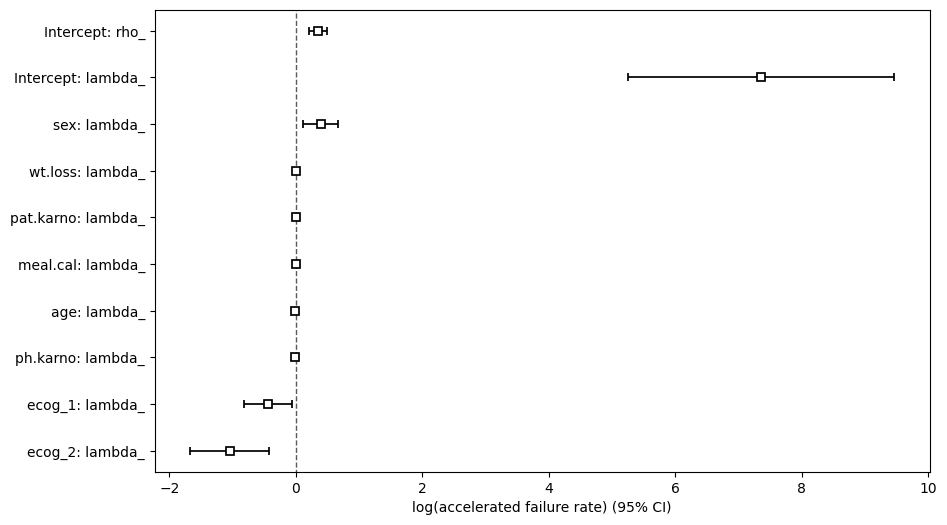

In [60]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()

**Plot Partial Effects on Outcome (Weibull Regression)**

We can use our fitted model to see how the survival changes as we change the covariate values. Here, I have used the plot_partial_effects_on_outcome( ) method to see how the survival varies among 50, 60, 70 and 80 years old patents compared to their baseline function. It clearly highlights that young patents has higher survival probabilities at any given instance of time compared to old patients.

<Axes: >

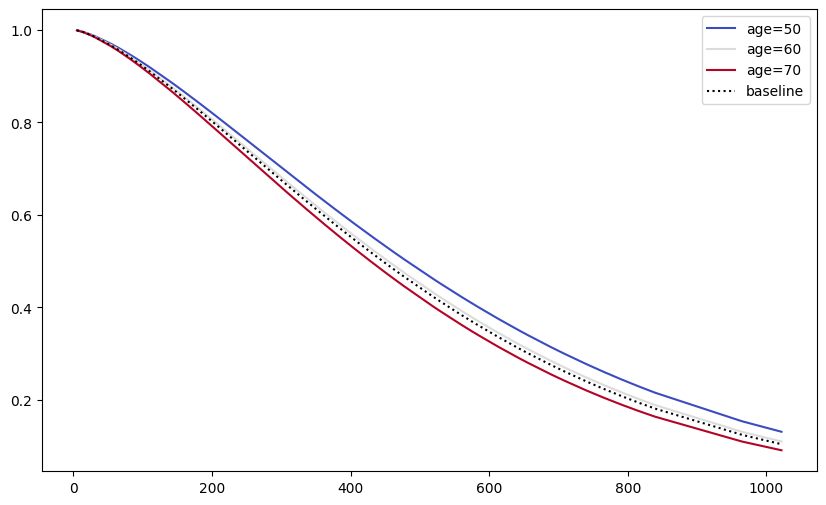

In [61]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot_partial_effects_on_outcome('age', range(50, 80, 10), cmap='coolwarm')

Survival analysis is a powerful technique for conducting time to event analysis

**References**

[1] Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective evaluation of prognostic variables from patient-completed questionnaires. North Central Cancer Treatment Group. Journal of Clinical Oncology. 12(3):601–7, 1994.

[2] Davidson-Pilon, (2019). lifelines: survival analysis in Python. Journal of Open Source Software, 4(40), 1317, https://doi.org/10.21105/joss.01317